In [1]:
import ira
from ira.analysis.kalman import kf_smoother, kalman_regression_estimator

from tqdm.notebook import tqdm
%alphalab dark

import qlearn as q
from sklearn.base import BaseEstimator, TransformerMixin

from c3p.models.utils import prepare_data
from alpha.utils.stat_helpers import cmp_to_norm

Reloaded /usr/local/envs/ira_p36/lib/python3.6/site-packages/ira/experimental/c_simulator_core.pyx


In [14]:
d = prepare_data('XBTUSD')

# Spread outliers trading

In [15]:
def spread_abs(x, y):
    d = x - y
    return d - d.iloc[0]

def spread_pct(x, y):
    return x / y - 1

def spread_ret(x, y):
    dr = x.pct_change() - y.pct_change()
    dr[~np.isfinite(dr)] = 0
    return (1 + dr).cumprod() - 1

def series_data(contract, cdata, timeframe='1h'):
    data = cdata.data[[contract.name, cdata.underlying]].ohlc(timeframe)
    
    if cdata.conv_symbol:
        data = {**data, **cdata.conv_data.ohlc(timeframe)}

    spread = None
    xd = retain_columns_and_join(data, 'close').dropna()
    if not xd.empty:
        f = xd[contract.name]
        if cdata.conv_symbol:
            f = f * xd[cdata.conv_symbol]
        u = xd[cdata.underlying]
        spread = f, u
    return spread

def basis(contract, cdata, spread_calculator=spread_abs, timeframe='1h'):
    data = cdata.data[[contract.name, cdata.underlying]].ohlc(timeframe)
    
    if cdata.conv_symbol:
        data = {**data, **cdata.conv_data.ohlc(timeframe)}

    spread = None
    xd = retain_columns_and_join(data, 'close').dropna()
    if not xd.empty:
        f = xd[contract.name]
        if cdata.conv_symbol:
            f = f * xd[cdata.conv_symbol]
        u = xd[cdata.underlying]
        spread = spread_calculator(f, u)
    return spread

def kfs(s, pvar, mvar):
    return pd.DataFrame(np.array(kf_smoother(s, pvar, mvar)).T, s.index, columns=['M', 'S'])

1. $S_t = F_t - U_t$, $\Delta S_t = S_t - M(S_t, N)$

2. when $| \Delta S_t | > T$ -> $\{+N \text{Sgn}(\Delta S_t), -N \text{Sgn}(\Delta S_t)\} $

In [5]:
tc = d.ctrs[-2]
s1 = basis(tc, d, spread_pct, timeframe='1d')
s2 = basis(tc, d, spread_ret, timeframe='1d')
s3 = basis(tc, d, spread_abs, timeframe='1d')
xs = s3

In [ ]:
for t in d.ctrs:
    print(f"['{t.name}', 'XBTUSD']")

In [610]:
bb = bollinger(xs, 48, 2, mean='ema', as_frame=True)
si = stochastic(xs, '5d', 3, 'sma')
kx = kfs(xs, 1e-6, 0.01)
ma1, st1 = kx.M, kx.S
ma2 = ema_time(xs, '7d')

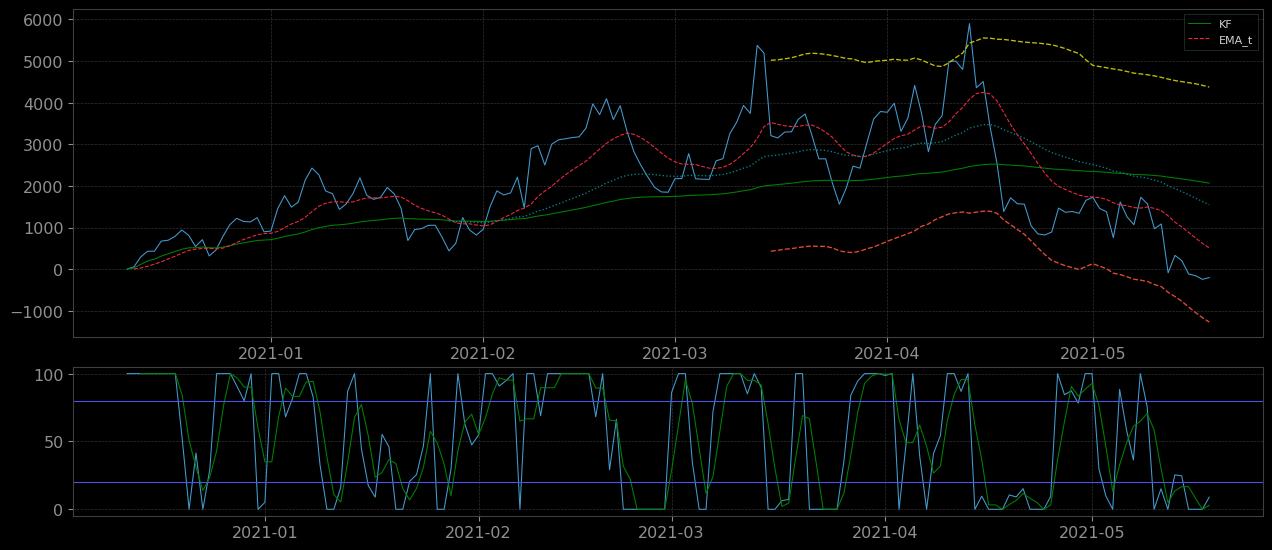

In [611]:
# _z = slice('2018-07-22', '2018-09-01')
_z = slice('2020-12-11', '2021-06-10')
fig(16, 7)

sbp(31, 1, r=2)
plt.plot(xs[_z])
plt.plot(ma1[_z], label='KF')
plt.plot(ma2[_z], '--', label='EMA_t')

plt.plot(bb.Upper[_z], '--', lw=1)
plt.plot(bb.Median[_z], ':', lw=1)
plt.plot(bb.Lower[_z], '--', lw=1)
plt.legend();

sbp(31, 3)
plt.plot(si[_z]); plt.axhline(80); plt.axhline(20)

In [ ]:
kxs = kfs(xs, 1e-6, 0.001)
ds = xs - kxs.M
# ds = xs - ema_time(xs, '5d')
# ds = xs - apply_to_frame(jma, xs, 5*24)

fig(16, 9)
plt.plot(ds)
plt.plot(+2*np.sqrt(kxs.S))
plt.plot(-2*np.sqrt(kxs.S))

In [ ]:
kxs.S

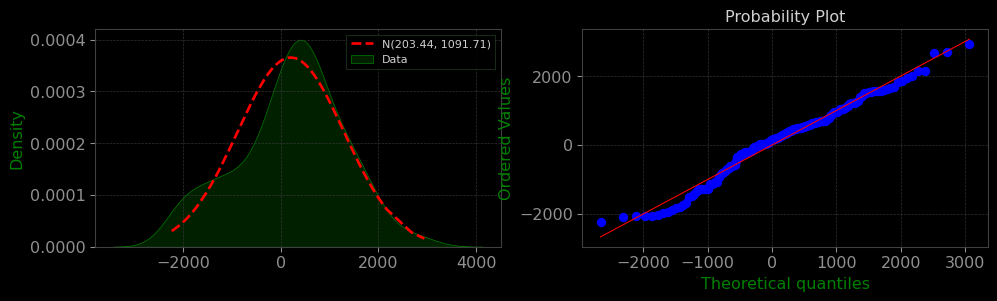

In [613]:
fig(12, 3)
cmp_to_norm(ds)

Regression

In [251]:
f, u = series_data(tc, d, '1h')

In [254]:
b, sprd, q = kalman_regression_estimator(f, u, 1e-6, 1, False)

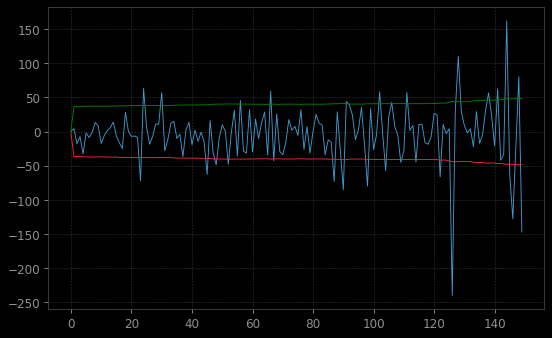

In [255]:
_z = slice(0, 150)
plt.plot(sprd[_z])
plt.plot(+2*np.sqrt(q)[_z])
plt.plot(-2*np.sqrt(q)[_z])

ETHUSD tests

In [4]:
d_eth = prepare_data('ETHUSD', 'XBTUSD')

In [12]:
tc = d_eth.ctrs[1]
s1 = basis(tc, d_eth, spread_pct, timeframe='1d')

In [ ]:
plt.plot(s1)